In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = load_iris()
X = data.data[data.target < 2].copy()
y = data.target[data.target < 2].copy()
print(data.data.shape)
print(data.target.shape)
print(data.target_names)

(150, 4)
(150,)
['setosa' 'versicolor' 'virginica']


In [3]:
np.random.seed(0)
order = np.arange(len(y))
np.random.shuffle(order)

In [4]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

## data

In [5]:
data = load_dataframe32("./bindata/data_013")
data["SK_ID_CURR"] = data.SK_ID_CURR.astype("int")

test = load_dataframe32("./bindata/test_013")
test["SK_ID_CURR"] = test.SK_ID_CURR.astype("int")

y = load_dataframe32("./bindata/y_013")
y["SK_ID_CURR"] = y.SK_ID_CURR.astype("int")

In [6]:
data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

In [7]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data_train = data_train.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    del nmf_data
    gc.collect()

buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data_train = data_train.merge(right=data_, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

for name in (
    "./bindata/bureau_and_balance_015",
    "./bindata/previous_applications_015",
    "./bindata/pos_cash_015",
    "./bindata/installments_payments_015",
    "./bindata/credit_card_balance_015",
):
    data_ = load_dataframe32(name)
    data_["SK_ID_CURR"] = data_.SK_ID_CURR.astype("int")
    data_train = data_train.merge(right=data_, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

In [9]:
data_train.shape, data_val.shape

((25803, 2030), (17390, 2030))

In [10]:
features_selected = list(np.load("./models/features-selected-016.npy"))

X_num_train = data_train[features_selected].values
X_num_val = data_val[features_selected].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

## bayesian optimization

In [ ]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.025,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 2000
}

In [17]:
import time

In [33]:
import lightgbm as lgb

train_data = lgb.Dataset(data=X_num_train, label=y_train)
n_folds = 2
random_seed = 0

def target_function(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    global train_data, nfolds, random_seed
    params = {
        # 'application':'binary',
        # "objective": "binary:logistic",
        "objective": "binary",
        "booster": "gbtree",
        'learning_rate':0.25,
        'num_iterations': 100,
        # 'early_stopping_round':10,
        'metric':'auc',
        "nthread": 4
    }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0.1)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0.1)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

In [34]:
params = {
    'num_leaves': 100,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'max_depth': 3,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'min_split_gain': 0,
    'min_child_weight': 10
}


a = time.time()
cv_auc = target_function(**params)
b = time.time()

print("time:", (b - a) / 60)
print("cv-auc", cv_auc)

C:\Anaconda2\envs\python3\lib\site-packages\lightgbm\engine.py:394: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


time: 0.17050975561141968
cv-auc 0.7506218199383303


1. 0.7265729959591269

In [27]:
from bayes_opt import BayesianOptimization

In [35]:
lgbBO = BayesianOptimization(
    target_function,
    {
        'num_leaves': (26, 40),
        'feature_fraction': (.1, .9),
        'bagging_fraction': (.6, .9),
        'max_depth': (5, 8.99),
        'lambda_l1': (0, 5),
        'lambda_l2': (0, 3),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (30, 45)
    },
    random_state=0)

In [36]:
lgbBO.maximize(init_points=10, n_iter=20)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 


C:\Anaconda2\envs\python3\lib\site-packages\lightgbm\engine.py:394: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


    1 | 00m07s |    0.75190 |             0.8936 |             0.7334 |      1.7975 |      1.7106 |      6.0556 |            44.6469 |           0.0167 |      33.6834 | 
    2 | 00m06s |    0.74842 |             0.8397 |             0.5231 |      2.1852 |      1.3158 |      8.0892 |            37.0298 |           0.0119 |      36.0127 | 
    3 | 00m07s |    0.74967 |             0.7384 |             0.5544 |      3.4882 |      2.9651 |      6.8200 |            44.6514 |           0.0660 |      34.4387 | 
    4 | 00m09s |    0.74692 |             0.8342 |             0.8405 |      0.3011 |      0.3061 |      7.2681 |            39.0727 |           0.0147 |      33.6284 | 
    5 | 00m02s |    0.75202 |             0.6355 |             0.1568 |      3.3338 |      0.6266 |      5.0750 |            41.0890 |           0.0205 |      31.9312 | 
    6 | 00m02s |    0.74482 |             0.7920 |             0.1697 |      3.3532 |      0.4839 |      7.4644 |            30.5878 |           0.037

C:\Anaconda2\envs\python3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.69977428e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Bayesian Optimization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
   11 | 00m34s |    0.74838 |             0.7750 |             0.8839 |      4.9597 |      1.8514 |      7.4590 |            44.2025 |           0.0979 |      26.0368 | 


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00012877]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   12 | 00m33s |    0.75172 |             0.7764 |             0.7606 |      4.8028 |      2.8394 |      5.3494 |            30.3744 |           0.0812 |      26.1987 | 
   13 | 00m31s |    0.74991 |             0.8319 |             0.4630 |      4.9079 |      0.8221 |      5.1966 |            44.8795 |           0.0262 |      39.7479 | 


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.06149396e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   14 | 00m34s |    0.75018 |             0.6068 |             0.8188 |      4.9146 |      2.8890 |      5.3408 |            32.5336 |           0.0461 |      38.7564 | 
   15 | 00m34s |    0.75504 |             0.8710 |             0.8051 |      4.9439 |      2.8593 |      5.0447 |            38.8275 |           0.0244 |      29.2553 | 
   16 | 00m33s |    0.75105 |             0.7726 |             0.8836 |      4.8657 |      0.1743 |      5.4657 |            44.8334 |           0.0859 |      30.5309 | 
   17 | 00m35s |    0.75075 |             0.6170 |             0.8525 |      0.2448 |      2.4803 |      5.4194 |            44.7620 |           0.0269 |      39.8037 | 
   18 | 00m34s |    0.74892 |             0.8033 |             0.8602 |      4.1609 |      0.1756 |      5.0966 |            32.8387 |           0.0143 |      26.2914 | 
   19 | 00m36s |    0.74467 |             0.8375 |             0.7313 |      4.9974 |      1.8083 |      8.4780 |            30.4602 |           0.044

C:\Anaconda2\envs\python3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.15187649e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   20 | 00m30s |    0.74835 |             0.6313 |             0.2694 |      1.6007 |      2.8382 |      5.2202 |            44.9706 |           0.0623 |      26.0019 | 
   21 | 00m38s |    0.74873 |             0.6700 |             0.8477 |      3.6861 |      0.1391 |      5.1634 |            37.0188 |           0.0355 |      39.1558 | 
   22 | 00m40s |    0.75047 |             0.6402 |             0.8557 |      0.1872 |      0.4638 |      8.9235 |            44.6401 |           0.0336 |      39.9100 | 


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00018658]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   23 | 00m39s |    0.75144 |             0.7079 |             0.8728 |      4.6294 |      1.7103 |      8.9336 |            30.4684 |           0.0396 |      39.6668 | 


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0004561]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   24 | 00m36s |    0.75050 |             0.8810 |             0.8689 |      4.7556 |      1.9220 |      8.7747 |            42.2508 |           0.0198 |      39.4596 | 
   25 | 00m36s |    0.74903 |             0.6282 |             0.8027 |      4.8360 |      2.6954 |      5.0282 |            43.0933 |           0.0192 |      27.2422 | 


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.89142302e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   26 | 00m37s |    0.75012 |             0.7765 |             0.8230 |      4.8760 |      2.9218 |      5.2426 |            30.5589 |           0.0978 |      30.9892 | 
   27 | 00m35s |    0.75070 |             0.6669 |             0.5026 |      0.2151 |      0.4161 |      8.8147 |            44.5976 |           0.0285 |      26.3898 | 
   28 | 00m37s |    0.74334 |             0.6911 |             0.7545 |      0.0230 |      2.7939 |      5.0359 |            30.5056 |           0.0012 |      26.8159 | 
   29 | 00m40s |    0.75045 |             0.7248 |             0.8766 |      4.2801 |      0.0903 |      8.9148 |            41.1738 |           0.0203 |      31.5343 | 
   30 | 00m37s |    0.75183 |             0.8797 |             0.7833 |      0.8308 |      0.0128 |      5.5074 |            42.9304 |           0.0806 |      26.1780 | 


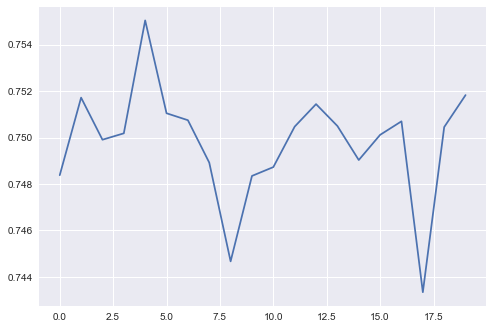

In [93]:
v_arr = lgbBO.res["all"]['values']
plt.plot(np.arange(len(v_arr)), v_arr)
plt.show()

## bayesian optimization  --sample

In [52]:
import seaborn as sns

In [82]:
def sample_function(a, b):
    return - a * a - b * b

sampleBO_0 = BayesianOptimization(sample_function, {"a": (-2, 2), "b": (-2, 2)}, random_state=0)

### range 0

In [83]:
sampleBO_0.maximize(init_points=10, n_iter=20)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         a |         b | 
    1 | 00m00s |   -1.39978 |    0.1953 |    1.1669 | 
    2 | 00m00s |   -0.75426 |    0.8608 |    0.1156 | 
    3 | 00m00s |   -0.24305 |    0.4111 |    0.2722 | 
    4 | 00m00s |   -2.93035 |    0.1795 |    1.7024 | 
    5 | 00m00s |   -3.03742 |   -0.3054 |   -1.7159 | 
    6 | 00m00s |   -3.06796 |    0.5836 |   -1.6515 | 
    7 | 00m00s |   -3.74537 |   -0.2497 |   -1.9191 | 
    8 | 00m00s |   -4.22595 |    1.5671 |    1.3305 | 
    9 | 00m00s |   -4.67767 |    1.8547 |    1.1126 | 
   10 | 00m00s |   -2.40792 |   -0.4662 |    1.4800 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         a |         b | 
   11 | 00m01s |   -4.13926 |   -2.0000 |   -0.3732 | 
   12 | 00m01s |   -8.00000 |   -2.0000 |    2.0000 | 
   13 | 00m01s |   -8.00000 |    2.0000 |   -2.0000 | 
   14 | 00m02s |   -0.15655 | 

In [60]:
colors = sns.cubehelix_palette(30, start=1.2, rot=.01)

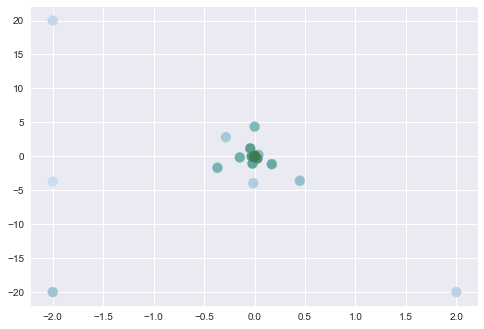

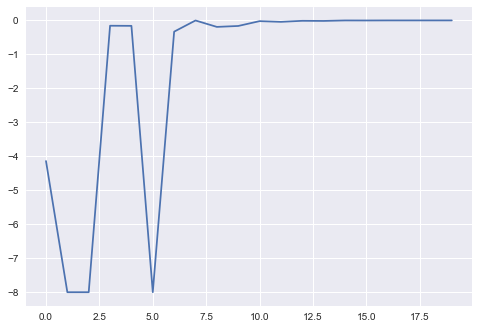

In [90]:
colors = sns.cubehelix_palette(30, start=1.5, rot=.5)
a_arr = [x["a"] for x in sampleBO_0.res["all"]["params"]]
b_arr = [x["b"] * 10 for x in sampleBO_0.res["all"]["params"]]

plt.scatter(a_arr, b_arr, color=colors, s=100)
plt.show()

v_arr = sampleBO_0.res["all"]['values']
plt.plot(np.arange(len(v_arr)), v_arr)
plt.show()

### range 1

In [85]:
sampleBO_1 = BayesianOptimization(sample_function, {"a": (-2, 2), "b": (-.2, .2)}, random_state=0)

sampleBO_1.maximize(init_points=10, n_iter=20)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         a |         b | 
    1 | 00m00s |   -0.05174 |    0.1953 |    0.1167 | 
    2 | 00m00s |   -0.74104 |    0.8608 |    0.0116 | 
    3 | 00m00s |   -0.16971 |    0.4111 |    0.0272 | 
    4 | 00m00s |   -0.06121 |    0.1795 |    0.1702 | 
    5 | 00m00s |   -0.12270 |   -0.3054 |   -0.1716 | 
    6 | 00m00s |   -0.36784 |    0.5836 |   -0.1651 | 
    7 | 00m00s |   -0.09916 |   -0.2497 |   -0.1919 | 
    8 | 00m00s |   -2.47348 |    1.5671 |    0.1330 | 
    9 | 00m00s |   -3.45211 |    1.8547 |    0.1113 | 
   10 | 00m00s |   -0.23928 |   -0.4662 |    0.1480 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         a |         b | 
   11 | 00m01s |   -4.04000 |   -2.0000 |   -0.2000 | 
   12 | 00m03s |   -0.03491 |   -0.1396 |    0.1242 | 
   13 | 00m04s |   -0.06053 |    0.1433 |   -0.2000 | 
   14 | 00m05s |   -0.00214 | 

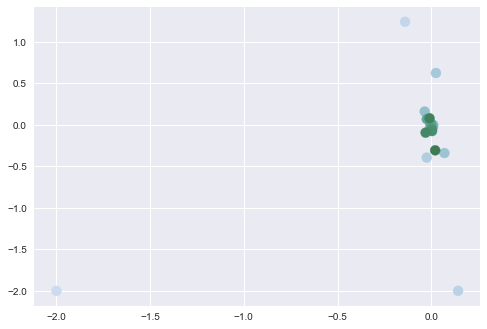

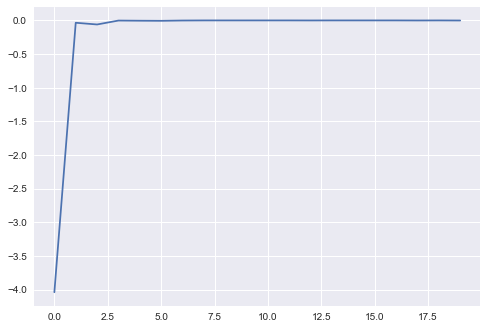

In [88]:
colors = sns.cubehelix_palette(30, start=1.5, rot=.5)
a_arr = [x["a"] for x in sampleBO_1.res["all"]["params"]]
b_arr = [x["b"] * 10 for x in sampleBO_1.res["all"]["params"]]

plt.scatter(a_arr, b_arr, color=colors, s=100)
plt.show()

v_arr = sampleBO_1.res["all"]['values']
plt.plot(np.arange(len(v_arr)), v_arr)
plt.show()

In [91]:
def sample_function(a, b):
    return - a * a - 100 * b * b

sampleBO_2 = BayesianOptimization(sample_function, {"a": (-2, 2), "b": (-2, 2)}, random_state=0)
sampleBO_2.maximize(init_points=10, n_iter=20)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         a |         b | 
    1 | 00m00s | -136.20372 |    0.1953 |    1.1669 | 
    2 | 00m00s |   -2.07677 |    0.8608 |    0.1156 | 
    3 | 00m00s |   -7.57706 |    0.4111 |    0.2722 | 
    4 | 00m00s | -289.84423 |    0.1795 |    1.7024 | 
    5 | 00m00s | -294.50936 |   -0.3054 |   -1.7159 | 
    6 | 00m00s | -273.08011 |    0.5836 |   -1.6515 | 
    7 | 00m00s | -368.36694 |   -0.2497 |   -1.9191 | 
    8 | 00m00s | -179.47332 |    1.5671 |    1.3305 | 
    9 | 00m00s | -127.23362 |    1.8547 |    1.1126 | 
   10 | 00m00s | -219.27176 |   -0.4662 |    1.4800 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         a |         b | 
   11 | 00m01s |  -14.49175 |   -2.0000 |   -0.3239 | 
   12 | 00m01s |   -0.71421 |    0.7747 |    0.0338 | 
   13 | 00m01s |   -0.70405 |    0.8157 |    0.0196 | 
   14 | 00m01s |   -0.74347 | 

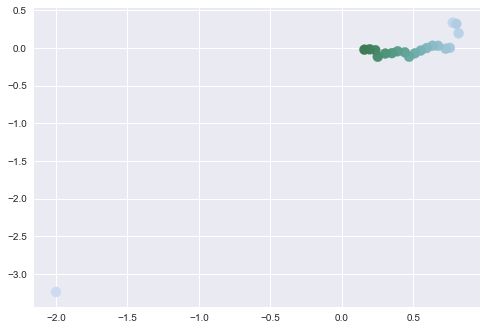

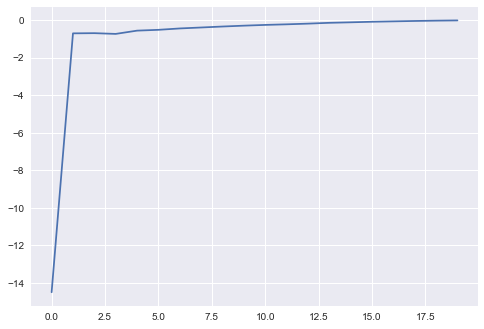

In [92]:
colors = sns.cubehelix_palette(30, start=1.5, rot=.5)
a_arr = [x["a"] for x in sampleBO_2.res["all"]["params"]]
b_arr = [x["b"] * 10 for x in sampleBO_2.res["all"]["params"]]

plt.scatter(a_arr, b_arr, color=colors, s=100)
plt.show()

v_arr = sampleBO_2.res["all"]['values']
plt.plot(np.arange(len(v_arr)), v_arr)
plt.show()